# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
import numpy as np

# Data
from survae.data.loaders.image import CIFAR10, MNIST
from torch.utils.data import DataLoader

# PyTorch
import torch
import torch.nn as nn


# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt
import corner

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [3]:
data = MNIST()
train_loader, test_loader = data.get_data_loaders(32)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# data.train.data[:500].shape, test_x.shape

In [5]:
test_x = data.train.data[:500].unsqueeze(1)

## Model

In [6]:
# np.prod((n_channels, height, width))

In [7]:
# model = Flow(base_dist=StandardNormal((24,8,8)),
#              transforms=[
#                UniformDequantization(num_bits=8),
#                Augment(StandardUniform((3,32,32)), x_size=3),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                Squeeze2d(), Slice(StandardNormal((12,16,16)), num_keep=12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                Squeeze2d(), Slice(StandardNormal((24,8,8)), num_keep=24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#              ]).to(device)

In [8]:
(np.prod((12,8,8)),)

(768,)

In [9]:
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.conv1x1 import Conv1x1Householder
from survae.transforms.bijections.linear_orthogonal import FastHouseholder
from survae.transforms.surjections.dequantization_uniform import UniformDequantization
from survae.transforms.bijections.reshape import Reshape
from survae.transforms.bijections.squeeze import Squeeze2d
from survae.transforms.surjections.slice import Slice

n_channels, height, width = 1, 28, 28
total_dims = np.prod((n_channels, height, width))




# transforms
num_mixtures = 12

transforms = [
    UniformDequantization(num_bits=8),
    GaussianMixtureCDF((1, 28, 28), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(1, 2),
    GaussianMixtureCDF((1, 28, 28), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(1, 2),
    GaussianMixtureCDF((1, 28, 28), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(1, 2),
    GaussianMixtureCDF((1, 28, 28), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(1, 2),
    GaussianMixtureCDF((1, 28, 28), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(1, 2),
    # (1,28,28) -> (4,14,14)
    Squeeze2d(), 
    GaussianMixtureCDF((4,14,14), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(4, 4),
    GaussianMixtureCDF((4,14,14), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(4, 4),
    GaussianMixtureCDF((4,14,14), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(4, 4),
    GaussianMixtureCDF((4,14,14), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(4, 4),
    GaussianMixtureCDF((4,14,14), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(4, 4),
    # (4,14,14) -> (16,7,7)
    Squeeze2d(), 
    GaussianMixtureCDF((16,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(16, 10),
    GaussianMixtureCDF((16,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(16, 10),
    GaussianMixtureCDF((16,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(16, 10),
    GaussianMixtureCDF((16,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(16, 10),
    GaussianMixtureCDF((16,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(16, 10),
    # (16,7,7) -> (8,7,7)
    Slice(StandardNormal((8,7,7)), num_keep=8),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    GaussianMixtureCDF((8,7,7), num_mixtures=num_mixtures), InverseGaussCDF(), Conv1x1Householder(8, 2),
    # (8,7,7) -> (98,)
    Reshape((8,7,7), (np.prod((8,7,7)),)), 
    GaussianMixtureCDF((392,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(392, 10),
    GaussianMixtureCDF((392,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(392, 10),
    GaussianMixtureCDF((392,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(392, 10),
    GaussianMixtureCDF((392,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(392, 10),
    GaussianMixtureCDF((392,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(392, 10),
    
]

# base distribution
base_dist = StandardNormal((np.prod((8,7,7)),))

# flow model
model = Flow(base_dist=base_dist, transforms=transforms)


In [10]:
loss = model.log_prob(test_x)

In [11]:
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision.transforms.functional as tv_F
import numpy as np

In [12]:
# def plot_images(data, num_x, num_y):
#     fig, ax = plt.subplots(num_x, num_y)
#     for i, ax in enumerate(ax.flatten()):
#         plottable_image = data[i]

#         if data.ndim == 2:
#             plottable_image = np.reshape(plottable_image, (3, 32, 32))

#         ax.imshow(plottable_image.transpose([1, 2, 0]), cmap="gray")
#         ax.axis("off")
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tv_F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [13]:
test_x.min(), test_x.max()


(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

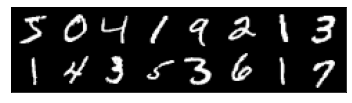

In [14]:
show(make_grid(test_x[:16]/255))

#### Demo: Forward & Inverse

In [15]:
%time
z, ldj = model.forward_transform(test_x)

CPU times: user 35 µs, sys: 5 µs, total: 40 µs
Wall time: 6.44 µs


In [16]:
%time
x_approx = model.inverse_transform(z[:32])

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 5.96 µs


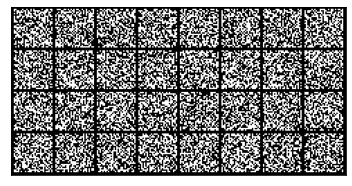

In [17]:
show(make_grid(x_approx[:32]/255))

#### Demo: Latent Space

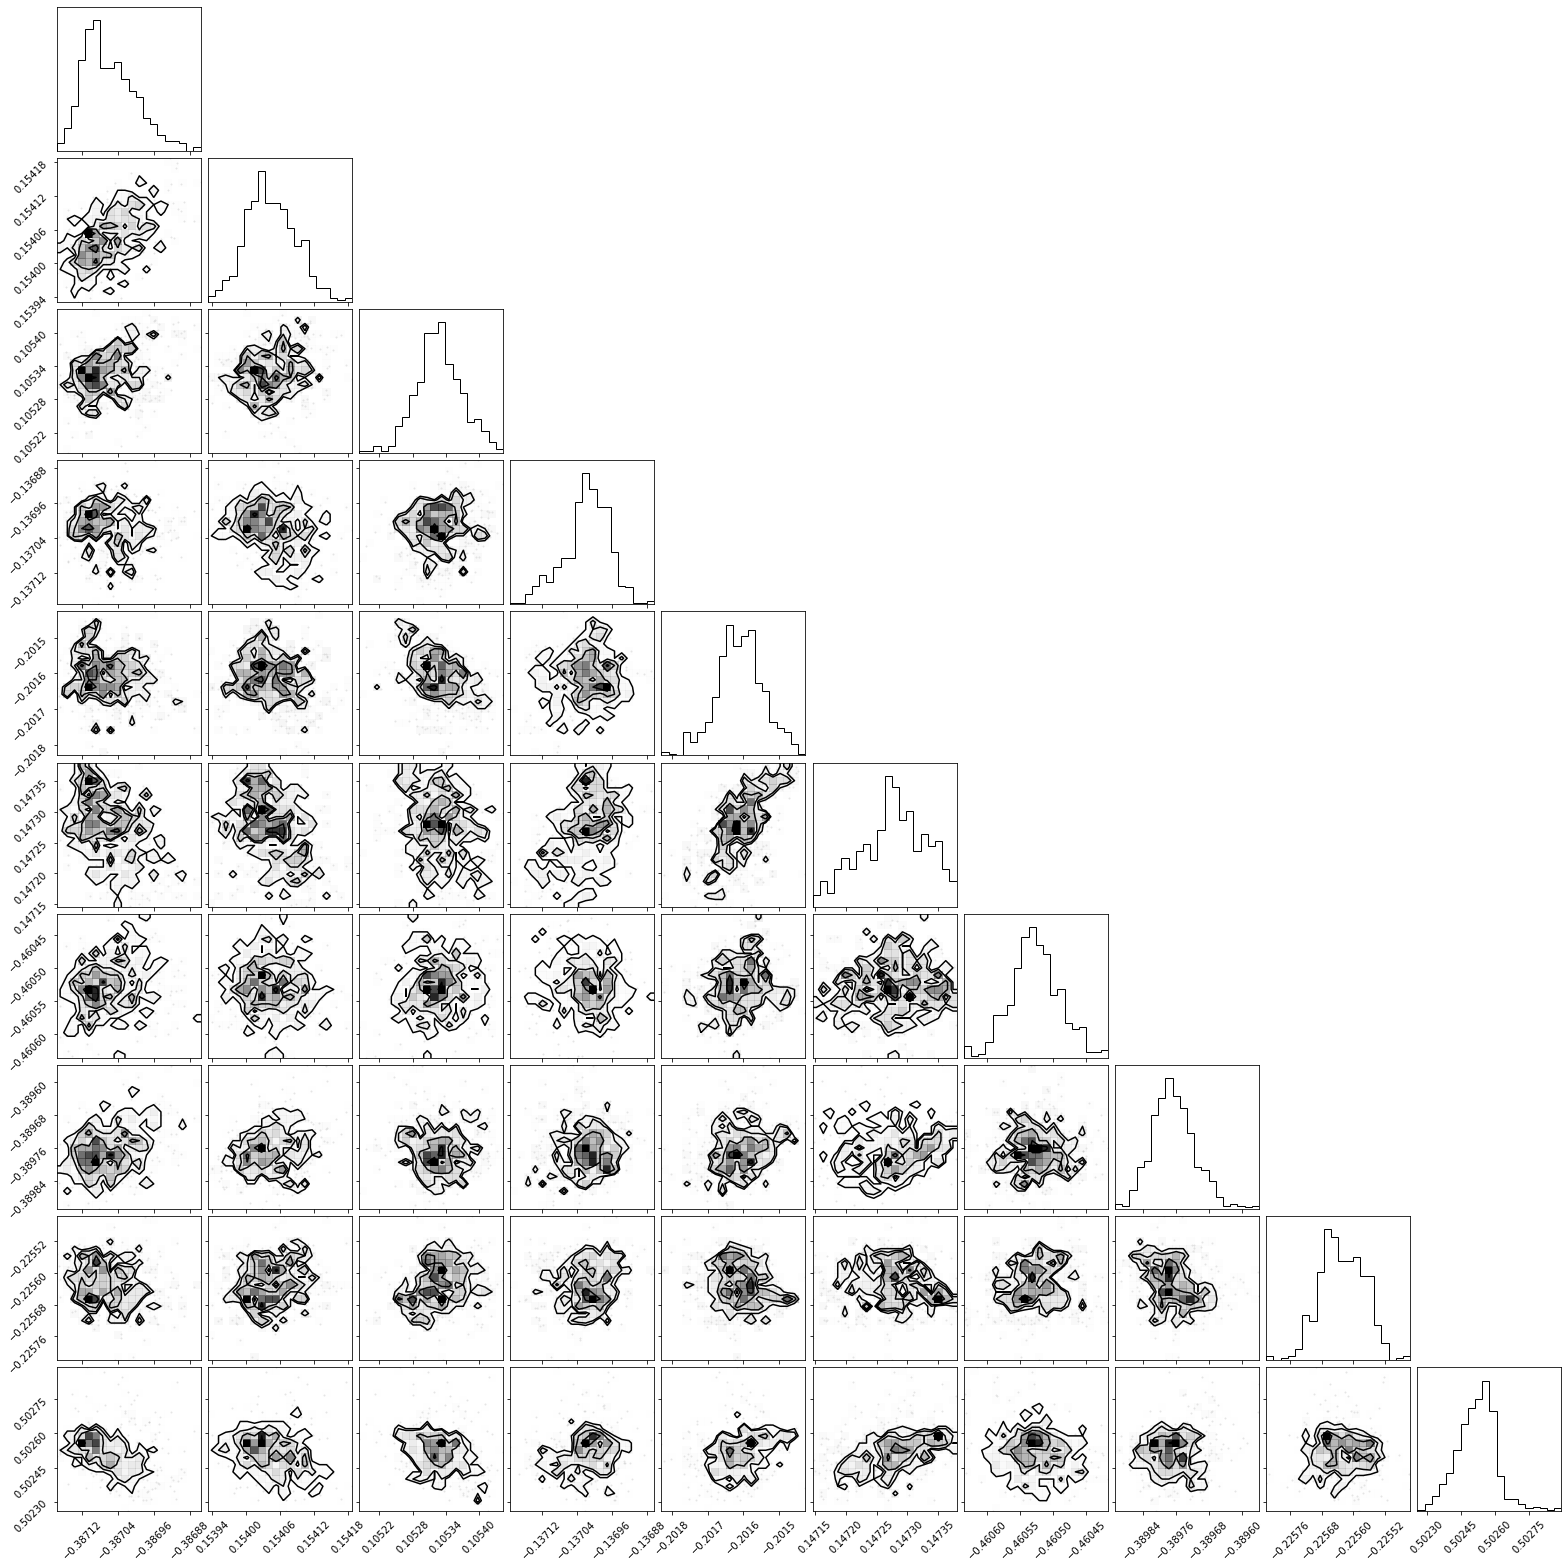

In [18]:


fig = corner.corner(z.detach().numpy()[:, :10])

#### Demo: Samples

In [19]:
%%time
print('Sampling...')
samples = model.sample(64).detach()

Sampling...
CPU times: user 53.5 s, sys: 2.2 s, total: 55.7 s
Wall time: 5.08 s


In [20]:
samples.shape

torch.Size([64, 1, 28, 28])

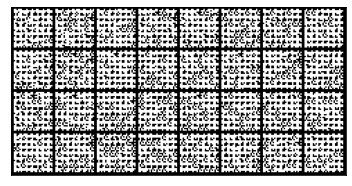

In [21]:
show(make_grid(samples[:32]/255))

In [22]:
# model = Flow(base_dist=StandardNormal((24,8,8)),
#              transforms=[
#                UniformDequantization(num_bits=8),
#                Augment(StandardUniform((3,32,32)), x_size=3),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                AffineCouplingBijection(net(6)), ActNormBijection2d(6), Conv1x1(6),
#                Squeeze2d(), Slice(StandardNormal((12,16,16)), num_keep=12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                AffineCouplingBijection(net(12)), ActNormBijection2d(12), Conv1x1(12),
#                Squeeze2d(), Slice(StandardNormal((24,8,8)), num_keep=24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#                AffineCouplingBijection(net(24)), ActNormBijection2d(24), Conv1x1(24),
#              ]).to(device)

## Trainer

In [23]:
import pytorch_lightning as pl
import math

class LearnerImage(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        
        # loss function
        loss = -self.model.log_prob(batch).sum() / (math.log(2) * batch.numel())
        
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-2)

    def train_dataloader(self):
        return train_loader

In [24]:
# initialize trainer
learn = LearnerImage(model)

In [ ]:
n_epochs = 10

# initialize trainer
trainer = pl.Trainer(min_epochs=1, max_epochs=n_epochs, gpus="1")

# train model
trainer.fit(learn)

/datadrive/eman/miniconda3/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/device_parser.py:135: LightningDeprecationWarning: Parsing of the Trainer argument gpus='1' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 1, but from v1.5 it will select gpus [0] (same as gpus=1 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params
-------------------------------
0 | model | Flow | 599 K 
-------------------------------
599 K     Trainable params
0         Non-trainable params
599 K     Total params
2.397     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

## Latent Space

In [ ]:
%time

z_latent, ldj = model.forward_transform(test_x)

In [ ]:
fig = corner.corner(z_latent.detach().numpy()[:, :10])

## Sampling

In [ ]:
%%time
print('Sampling...')
samples = model.sample(64).detach()

In [ ]:
show(make_grid(samples[:32]/255))